## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [1]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:00<00:00, 108MB/s]


In [2]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=88a5c835-3b58-4cfb-be78-3cd84b4bc4e5
To: /content/coco_captions.npy
100% 415M/415M [00:05<00:00, 70.4MB/s]


In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [5]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)


loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [6]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


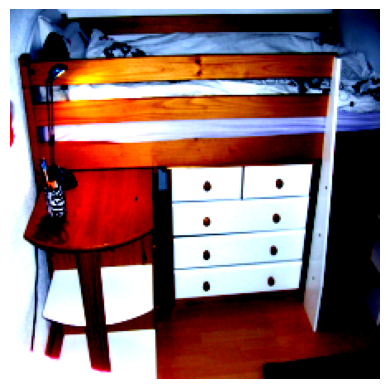

['A loft bed with a dresser underneath it.'
 'A bed and desk in a small room.' 'Wooden bed on top of a white dresser.'
 'A bed sits on top of a dresser and a desk.'
 'Bunk bed with a narrow shelf sitting underneath it. ']


In [7]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))  # permute to change the order of dimensions
plt.axis('off')  # hide axis labels
plt.show()
print(captions_np[3])

In [8]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [9]:
captions_flat[15:20]

['A loft bed with a dresser underneath it.',
 'A bed and desk in a small room.',
 'Wooden bed on top of a white dresser.',
 'A bed sits on top of a dresser and a desk.',
 'Bunk bed with a narrow shelf sitting underneath it. ']

In [10]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [11]:
len(caption_embeddings), len(caption_embeddings[0]), len(caption_embeddings[0][0])

(40504, 5, 512)

In [12]:
caption_embeddings[3]

array([[ 0.02299822, -0.03677031,  0.04210469, ...,  0.0563297 ,
         0.00238412, -0.04633193],
       [-0.0271877 , -0.00789524,  0.02026796, ..., -0.00635479,
        -0.02450683, -0.04219217],
       [-0.01896541, -0.01847135,  0.02910154, ...,  0.04456075,
        -0.00972973, -0.07108045],
       [-0.01062478, -0.01790594,  0.02283338, ...,  0.03015121,
        -0.01349179, -0.06305943],
       [ 0.01491319, -0.0413617 ,  0.02106383, ...,  0.02988766,
         0.00097947, -0.04540596]], dtype=float32)

In [13]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape, image_embeddings[0].shape)

Image embeddings (40504, 512) (512,)


In [14]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)

In [15]:
index = faiss.IndexFlatL2(512)
index.add(image_embeddings)

In [16]:
len(image_embeddings[3])

512

In [17]:
print(index.ntotal)
print(index.d)

40504
512


In [18]:
index

<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7d3dab315c20> >

In [19]:
k = 3
distances, indices = index.search(image_embeddings, k)

In [20]:
distances.shape, distances[3], indices[3]

((40504, 3),
 array([0.        , 0.29426908, 0.31794596], dtype=float32),
 array([    3, 27851, 22945]))

In [21]:
def dbg_img(idx):
  img , caption = coco_dset[idx]
  plt.imshow(img.permute(1, 2, 0))
  plt.axis('off')  # hide axis labels
  plt.show()
  print(captions_np[idx])



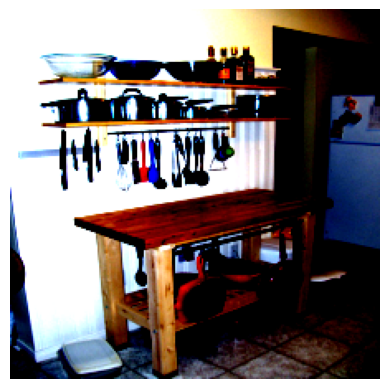

['A kitchen shelf holds an assortment of pots, pans, and utensils.'
 'A wooden table in a kitchen with pots and pans.'
 'A cutting board , pot rack and dish shelf.'
 'A utility table in a kitchen, with pots, pans and utensils hanging nearby.'
 'a table in a kitchen some pots and pans and hanging utensils']


In [22]:
img_1 , caption_1 = coco_dset[27851]
img_2, caption_2  = coco_dset[22945]
# plt.imshow(img_1.permute(1, 2, 0))  # permute to change the order of dimensions
# plt.axis('off')  # hide axis labels
# plt.show()
# print(captions_np[27851])
dbg_img(27851)

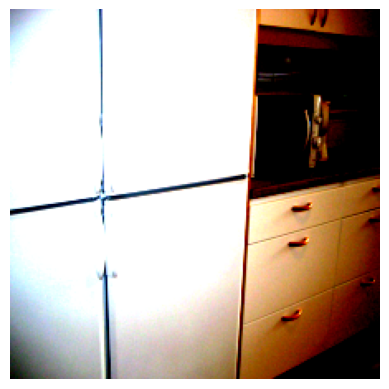

['A plain kitchen with white and wood decor.'
 'The white refrigerator is next to a microwave on the kitchen counter. '
 'A kitchen with wooden countertops and a large, white, refrigerator.'
 'A close up look at a very big white fridge and some cabinets.'
 'A close view of kitchen cabinets and drawers.']


In [23]:
dbg_img(22945)

![alt text](https://imagizer.imageshack.com/img923/3021/DET2Ez.png)

In [54]:
def get_similarity(i, j):
  img_1 = image_embeddings[i]
  img_2 =  image_embeddings[j]
  return np.dot(img_1, img_2)

get_similarity(0, 1), get_similarity(3, 22945), get_similarity(3, 27851)

(0.55038315, 0.84058166, 0.8528619)

In [25]:
def caption_sum(i):
  return np.sum(caption_embeddings[i], axis=0)

caption_embeddings[3].shape, caption_sum(3)[0]

((5, 512), -0.018866481)

In [26]:
sum = 0
for x in caption_embeddings[3]:
  sum += x[0]
sum

-0.018866483122110367

In [27]:
"""
distances has 45k rows (each for an image) with k columns
TODO: modify this to index != i condition (??)
"""
query_vectors = []
for i in range(len(image_embeddings)):
  # iterate over all the neighbours
  distance_k, index_k = distances[i], indices[i]  #k size arrays
  Cil = caption_sum(i)
  sim = 0
  for j in index_k:
    sim += get_similarity(i, j)

  query_vector = (sim/(2*k)) * Cil
  # if i == 3 :
  #   print(Cil, sim, (sim/2*k) *query_vector)
  query_vectors.append(query_vector)



In [28]:
query_vectors[3].shape

(512,)

In [29]:
query_distance, query_idx = index.search(query_vectors[3].reshape(1, -1), k)

In [30]:
query_distance, query_idx

(array([[3.9078503, 3.9316957, 3.9590416]], dtype=float32),
 array([[19783,     3, 13486]]))

In [31]:
print(captions_np[19783]," \n\n", captions_np[13486], "\n\n", captions_np[3])

['A bedroom with an old bedspread and a very cluttered wooden night stand.'
 'A bed between a night stand and bureau with a flowered comforter and a pile of books in the corner on the night stand.'
 'Comforter covered bed in semi unkempt bright bedroom.'
 'A bed roughly made with a flowered quilt '
 'A bed sitting next to two dressers and a chair by a window.']  

 ['A small room has a bed and desk with a laptop.'
 'A bedroom with a computer desk next to bed, and bookcase above head. '
 'A bedroom with a laptop on a computer desk next to a bed'
 'A bedroom setup with overhead bookshelf and computer desk'
 'A bedroom with an almost empty bookshelf and desk'] 

 ['A loft bed with a dresser underneath it.'
 'A bed and desk in a small room.' 'Wooden bed on top of a white dresser.'
 'A bed sits on top of a dresser and a desk.'
 'Bunk bed with a narrow shelf sitting underneath it. ']


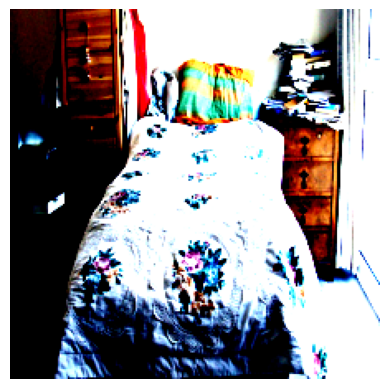

['A bedroom with an old bedspread and a very cluttered wooden night stand.'
 'A bed between a night stand and bureau with a flowered comforter and a pile of books in the corner on the night stand.'
 'Comforter covered bed in semi unkempt bright bedroom.'
 'A bed roughly made with a flowered quilt '
 'A bed sitting next to two dressers and a chair by a window.']


In [32]:
dbg_img(19783)

In [33]:
check_lst = captions_np[19783]
check_lst = [x.split() for x in check_lst]
real_lst = [x.split() for x in captions_np[3]]
# check_lst
accuracy(check_lst, real_lst)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

8.735016255182394e-232

In [151]:
#@title Fiass  KNN Class
class FiassKNN:
  def __init__(self, embeddings, k):
    self.index = faiss.IndexFlatL2(512)
    self.index.add(image_embeddings)
    self.distances, self.indices = self.index.search(image_embeddings, k)
    self.embeddings = embeddings
    self.query_vectors = []
    self.k = k + 1
    self.index_caption = faiss.IndexFlatIP(512)

  def generate_query_vectors(self):
    self.query_vectors = []
    for i in range(len(self.embeddings)):
      # iterate over all the neighbours
      distance_k, index_k = self.distances[i], self.indices[i]  #k size arrays
      Cil = caption_sum(i)
      sim = 0
      for j in index_k:
        sim += get_similarity(i, j)

      query_vector = (sim/(2*(self.k))) * Cil
      # if i == 3 :
      #   print(Cil, sim, (sim/2*k) *query_vector)
      self.query_vectors.append(query_vector)

  def generate_caption_embeddings(self, caption_embeddings):
    caption_embeddings_flat = caption_embeddings.reshape(40504 *5, 512)
    caption_embeddings_flat /= np.linalg.norm(caption_embeddings_flat, axis=1, keepdims=True) # normalize for cosine similairty
    self.index_caption.add(caption_embeddings_flat)


  def predict(self, i):
    query = self.query_vectors[i].reshape(1, -1)
    query /= np.linalg.norm(query, axis=1, keepdims=True) # normalize for coasine similarity
    distances, indices = self.index_caption.search(query, 5*self.k)
    return distances, indices

In [69]:
caption_embeddings.shape , image_embeddings.shape

((40504, 5, 512), (40504, 512))

In [73]:
k = 3
model = FiassKNN(image_embeddings, k)

In [74]:
model.generate_query_vectors()


In [75]:
model.generate_caption_embeddings(caption_embeddings)

In [76]:
distance_vector, indices = model.predict(3)

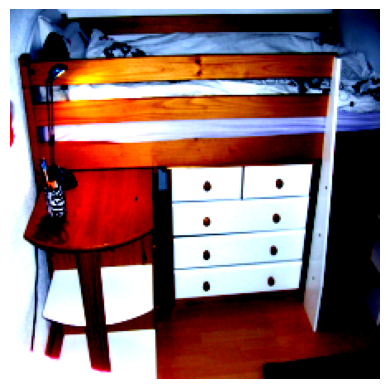

['A loft bed with a dresser underneath it.'
 'A bed and desk in a small room.' 'Wooden bed on top of a white dresser.'
 'A bed sits on top of a dresser and a desk.'
 'Bunk bed with a narrow shelf sitting underneath it. ']


In [77]:
dbg_img(3)

In [78]:
indices

array([[    18, 194803,  59896,     19,     17, 180393,     16, 168099,
         13232,  13231,  63989, 200474, 116206, 156802,  60509,  80447,
         66233, 177634,  55475,  11018]])

In [41]:
18%5 + int(18/5)
captions_np.shape

(40504, 5)

In [79]:
captions_np[int(194803/5)][194803%5], captions_np[3]

('A large bed sitting up against a wooden dresser.',
 array(['A loft bed with a dresser underneath it.',
        'A bed and desk in a small room.',
        'Wooden bed on top of a white dresser.',
        'A bed sits on top of a dresser and a desk.',
        'Bunk bed with a narrow shelf sitting underneath it. '],
       dtype='<U250'))

In [43]:
predicted_caption_lst = [(captions_np[int(59896/5)][59896%5])]
real_caption_lst = [captions_np[3].tolist()]
# real_caption_lst = [captions_np[3]]
predicted_caption_lst, real_caption_lst # predicted caption is a list of one string, real caption is a list of 5 strings

(['Small bunk bed in the corner of a bedroom.'],
 [['A loft bed with a dresser underneath it.',
   'A bed and desk in a small room.',
   'Wooden bed on top of a white dresser.',
   'A bed sits on top of a dresser and a desk.',
   'Bunk bed with a narrow shelf sitting underneath it. ']])

In [80]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre), weights=(1.,))
        accuracy += score
    return accuracy/len(predict)

predict = ['A large bed sitting up against a wooden dresser.']
real = [['A loft bed with a dresser underneath it.',
          'A bed and desk in a small room.',
          'Wooden bed on top of a white dresser.',
          'A bed sits on top of a dresser and a desk.',
          'Bunk bed with a narrow shelf sitting underneath it.']]
print('accuracy_v2:',accuracy_v2(predict,real))

accuracy_v2: 0.6666666666666666


In [45]:
accuracy_v2(predicted_caption_lst, real_caption_lst)

0.6666666666666666

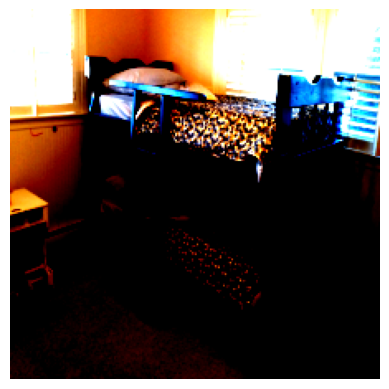

['The bunk beds are made up with the same bedding. '
 'Small bunk bed in the corner of a bedroom.'
 'a small wooden bunkbed sits in the corner of a room near some windows.'
 'a bunk bed sitting in the corner of the bedroom '
 'There are bunk beds in the childrens room.']


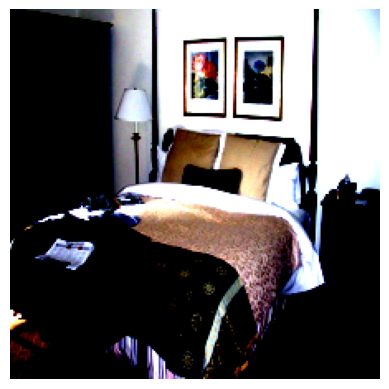

['A suitcase sitting on a bench in front of a bed.'
 'A suitcase next to a large bed in a nicely furnished room.'
 'A clean bedroom with a large bed and dresser.'
 'A large bed sitting up against a wooden dresser.'
 'The guest room is decorated in colonial style.']


(None, None)

In [46]:
from math import ceil, floor
dbg_img(int(59896/5)), dbg_img(floor((194803)/5))  # take floor not ceil !

In [113]:
import time
k_vals = [1, 3, 5, 7, 9]
real_indices = [3, 10, 151, 204, 1738]
models = []
all_distances, all_indices = [], []
for k in k_vals:
  start = time.time()
  model = FiassKNN(image_embeddings, k)
  model.generate_query_vectors()
  model.generate_caption_embeddings(caption_embeddings)
  models.append(model)
  distance_vector, indices = model.predict(k)
  all_distances.append(distance_vector)
  all_indices.append(indices)
  print(f"Time taken for k:{k}  = {time.time() - start}")



Time taken for k:1  = 31.194270372390747
Time taken for k:3  = 30.151827335357666
Time taken for k:5  = 29.47945809364319
Time taken for k:7  = 31.83300280570984
Time taken for k:9  = 30.619360208511353


In [114]:
[len(x[0]) for x in all_distances] # (idx + 1) * 5

[10, 20, 30, 40, 50]

In [115]:
# Lets test for accuracies, we tried predicted index 1, 3, 5, 7 stored at index 0 1 2 3
def closest_predicted_caption(i, real_k): # closest image caption for image i , having real value k
  indexes = list(all_indices[i][0])
  j = 0
  while int(indexes[j]/5) == real_k:
    j+=1
  return indexes[j]


In [132]:
predictions, real, accuracies = [], [], []

for i, val in enumerate(k_vals):
    p_idx = closest_predicted_caption(i, val)
    predicted = captions_np[int(p_idx/5)][p_idx%5]
    greal = captions_np[val].tolist()
    accuracy = accuracy_v2([predicted], [greal])
    print(f"accuracy for k={val}, {accuracy}")
    predictions.append(predicted)
    real.append(greal)
    accuracies.append(accuracy)

accuracy for k=1, 0.7777777777777778
accuracy for k=3, 0.6666666666666666
accuracy for k=5, 0.6363636363636364
accuracy for k=7, 0.5454545454545454
accuracy for k=9, 0.4166666666666667


In [126]:
predictions, real

(['A motorcycle that is parked in a parking spot.',
  'A large bed sitting up against a wooden dresser.',
  'The woman is standing in the kitchen close to the table.',
  'a small kitchen adjacent to a living room and dining area',
  'A table with various foods ready to eat on plates and bowls.'],
 [['A motorcycle parked in a parking space next to another motorcycle.',
   'An old motorcycle parked beside other motorcycles with a brown leather seat.',
   'Motorcycle parked in the parking lot of asphalt.',
   'A close up view of a motorized bicycle, sitting in a rack. ',
   'The back tire of an old style motorcycle is resting in a metal stand. '],
  ['A loft bed with a dresser underneath it.',
   'A bed and desk in a small room.',
   'Wooden bed on top of a white dresser.',
   'A bed sits on top of a dresser and a desk.',
   'Bunk bed with a narrow shelf sitting underneath it. '],
  ['A woman stands in the dining area at the table.',
   'A room with chairs, a table, and a woman in it.',
 

In [127]:
accuracy_v2(predictions, real)

0.6085858585858586

Lets visualize all these images, in the ground reality

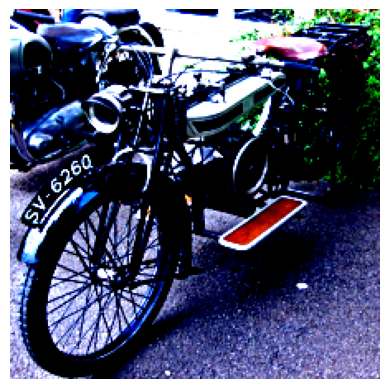

['A motorcycle parked in a parking space next to another motorcycle.'
 'An old motorcycle parked beside other motorcycles with a brown leather seat.'
 'Motorcycle parked in the parking lot of asphalt.'
 'A close up view of a motorized bicycle, sitting in a rack. '
 'The back tire of an old style motorcycle is resting in a metal stand. ']


(None, 'Predicted caption : A motorcycle that is parked in a parking spot.')

In [133]:
prnt = f"Predicted caption : {predictions[0]}"
dbg_img(1), prnt

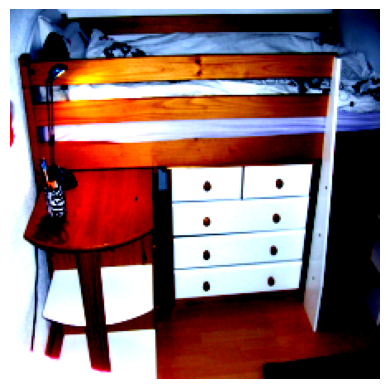

['A loft bed with a dresser underneath it.'
 'A bed and desk in a small room.' 'Wooden bed on top of a white dresser.'
 'A bed sits on top of a dresser and a desk.'
 'Bunk bed with a narrow shelf sitting underneath it. ']


(None, 'Predicted caption : A large bed sitting up against a wooden dresser.')

In [134]:
prnt = f"Predicted caption : {predictions[1]}"
dbg_img(3), prnt

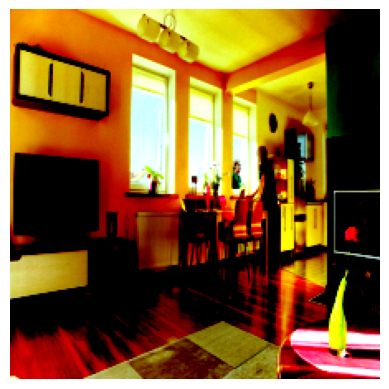

['A woman stands in the dining area at the table.'
 'A room with chairs, a table, and a woman in it.'
 'A woman standing in a kitchen by a window'
 'A person standing at a table in a room.'
 'A living area with a television and a table']


(None,
 'Predicted caption : The woman is standing in the kitchen close to the table.')

In [141]:
prnt = f"Predicted caption : {predictions[2]}"
dbg_img(5), prnt

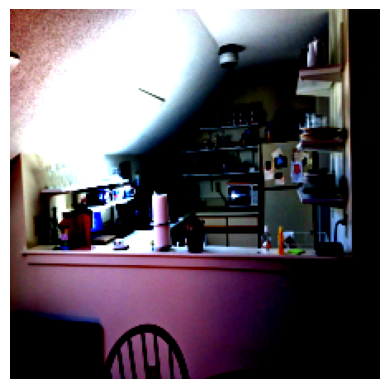

['A small kitchen with low a ceiling '
 'A small kichen area with a sunlight and and angled ceiling.'
 'an image of a kitchen loft style setting'
 'a small kitchen with a lot of filled up shelves '
 'A kitchen with a slanted ceiling and skylight.']


(None,
 'Predicted caption : a small kitchen adjacent to a living room and dining area')

In [142]:
prnt = f"Predicted caption : {predictions[3]}"
dbg_img(7), prnt

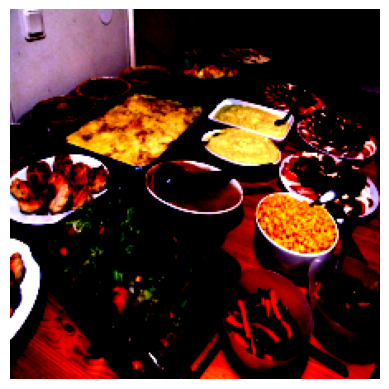

['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']


(None,
 'Predicted caption : A table with various foods ready to eat on plates and bowls.')

In [143]:
prnt = f"Predicted caption : {predictions[4]}"
dbg_img(9), prnt

# Observations
- The model seems to be doing pretty well, we have tested against various values of `k` for every model, the time taken to train them is roughly the same for lower values of 'k'
- The bleu score dropped from 77% to 43% although the entire set still has an accuracy of 63%. The bleu score isnt a very good indication of how good the model is since there are overlaps while computing them.
- The value of `k` does seem to decrease witht he increasing value of accuracy, we have predicted at most `k*5` captions for each image since there will be atmost 5 captions which come from the samge image. (We couldve also done `k+5`)
- We will now fix the value of `k` at `3` and try to optimize the model.

In [144]:
k = 3
start = time.time()
model = FiassKNN(image_embeddings, k)
model.generate_query_vectors()
model.generate_caption_embeddings(caption_embeddings)
time_taken = time.time() - start
time_taken

31.824913024902344

In [152]:
#@title Fiass  KNN Class Optimization techniques
class FiassKNNOptimized:
  def __init__(self, embeddings, k, option):
    # if option == 0:
    #   self.index = faiss.IndexIVFPQ(512, 100, 16, 8) #chatgpt suggested values

    if option == 0:
      self.index = faiss.IndexHNSWFlat(512, 32)

    elif option == 1:
      quantizer = faiss.IndexFlatL2(512)
      self.index = faiss.IndexIVFFlat(quantizer, 512, 16)

    self.index.train(embeddings)
    self.index.add(image_embeddings)
    self.distances, self.indices = self.index.search(image_embeddings, k)
    self.embeddings = embeddings
    self.query_vectors = []
    self.k = k + 1
    self.index_caption = faiss.IndexFlatIP(512)

  def generate_query_vectors(self):
    self.query_vectors = []
    for i in range(len(self.embeddings)):
      # iterate over all the neighbours
      distance_k, index_k = self.distances[i], self.indices[i]  #k size arrays
      Cil = caption_sum(i)
      sim = 0
      for j in index_k:
        sim += get_similarity(i, j)

      query_vector = (sim/(2*(self.k))) * Cil
      # if i == 3 :
      #   print(Cil, sim, (sim/2*k) *query_vector)
      self.query_vectors.append(query_vector)

  def generate_caption_embeddings(self, caption_embeddings):
    caption_embeddings_flat = caption_embeddings.reshape(40504 *5, 512)
    caption_embeddings_flat /= np.linalg.norm(caption_embeddings_flat, axis=1, keepdims=True) # normalize for cosine similairty
    self.index_caption.add(caption_embeddings_flat)


  def predict(self, i):
    query = self.query_vectors[i].reshape(1, -1)
    query /= np.linalg.norm(query, axis=1, keepdims=True) # normalize for coasine similarity
    distances, indices = self.index_caption.search(query, 5*self.k)
    return distances, indices

In [154]:
model_optimized = []
for i in range(2):
  k = 3
  start = time.time()
  model = FiassKNNOptimized(image_embeddings, k, i)
  model.generate_query_vectors()
  model.generate_caption_embeddings(caption_embeddings)
  time_taken = time.time() - start
  model_optimized.append(model)
  print(f"Time taken for model: {i+1}, {time_taken}")

Time taken for model: 1, 23.483505725860596
Time taken for model: 2, 25.12000322341919


- **IndexHNSW**: Hierarchical Navigable Small World index for fast approximate nearest neighbor search.

- **IndexIVFFlat**: Uses inverted file indexing for faster search.

- **IndexIVFPQ**: Uses product quantization for fast approximate nearest neighbor search. (could not configure this)

- **IndexIVFFlatL2**: Similar to IndexIVFFlat but with L2 (Euclidean) distance metric. (Directly built this)

In [155]:
real_indices

[3, 10, 151, 204, 1738]

In [156]:
  distance_vector_1, indices_1 = model_optimized[0].predict(k)

In [157]:
indices_1

array([[    18, 194803,  59896,     19,     17, 180393,     16, 168099,
         13232,  13231,  63989, 200474, 116206, 156802,  60509,  80447,
         66233, 177634,  55475,  11018]])

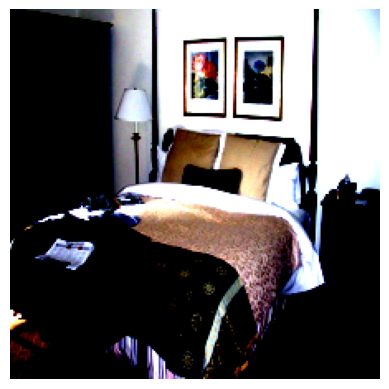

['A suitcase sitting on a bench in front of a bed.'
 'A suitcase next to a large bed in a nicely furnished room.'
 'A clean bedroom with a large bed and dresser.'
 'A large bed sitting up against a wooden dresser.'
 'The guest room is decorated in colonial style.']


(None, 'A large bed sitting up against a wooden dresser.')

In [159]:
dbg_img(int(194803/5)), captions_np[int(194803/5)][194803%5]

In [161]:
  distance_vector_2, indices_2 = model_optimized[1].predict(k)
  indices_2

array([[    18, 194803,  59896,     19,     17, 180393,     16, 168099,
         13232,  13231,  63989, 200474, 116206, 156802,  60509,  80447,
         66233, 177634,  55475,  11018]])

In [162]:
predicted = captions_np[int(194803/5)][194803%5]
greal = captions_np[3].tolist()
accuracy_v2([predicted], [greal])

0.6666666666666666

# Observations

- We tried predicting with two models, the training time did reduce in both the cases when compared to the normal search method.
- The faiss factory methods we used also required training on the embeddings, keeping that in mind is important since despite the training the time had reduced.
- The bleu score turned out to be 66%, not a very important metric.
- The predictions are exactly the same as the one in our original model, which is why we havent tested accuracy rigirously.

